In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

In [2]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [3]:
dataset_path = download_dataset() + "/names.txt"

100%|██████████| 113k/113k [00:00<00:00, 394kB/s]

Extracting files...


In [4]:
words = open(dataset_path, 'r').read().splitlines()

In [5]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [6]:
ctoi, itoc = make_int_char_maps()

In [7]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [7]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [8]:
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:

  block_size = 3 # context length -> how many chars does it take to predict the next
  inp, target = [], []
  for w in inp_words:
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [9]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [ ]:
Xtr.shape, Xval.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [ ]:
inp, target = build_dataset(words)

In [ ]:
inp.shape, target.shape, inp.dtype, target.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [ ]:
C = torch.randn(27, 2) # 27 characters mapping to a 2d vector embedding`

In [ ]:
C[5]

tensor([-2.2621, -1.0324])

In [ ]:
(F.one_hot(torch.tensor(5), num_classes=27).float() @ C) # one hot allows us to pluck out a desired row
                                                         # however, notice its the same as indexing, so this wont be used

tensor([-2.2621, -1.0324])

inp contains contexts, defined in build dataset above
each context contains index mappings from ctoi.
these allow us to access embeddings in C.
we can index into C efficienty with the help of PyTorch

In [ ]:
C[inp].shape

torch.Size([228146, 3, 2])

In [11]:
n_emb = 10 # number of dimensions in emb
n_hidden = 200 # number of neurons in hidden layer
block_size = 3 # size of each context

C = torch.randn((vocab_size, n_emb))
emb = C[Xtr]
W1 = torch.randn((n_emb * block_size, n_hidden)) # this is our hiddem layer, recieving 6 inputs, since each input has three characters, each having two elements
B1 = torch.randn(n_hidden) # 100 biases for each weight

In [12]:
h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + B1)

In [13]:
h

tensor([[-0.9998, -0.9812,  1.0000,  ...,  0.9423, -0.9996, -0.1811],
        [ 0.6917,  0.6984,  1.0000,  ...,  1.0000, -0.9522,  0.9433],
        [ 0.9620,  0.9999,  0.2111,  ..., -0.0852,  0.9998,  0.9858],
        ...,
        [-0.5529, -0.7079, -0.9936,  ...,  1.0000,  0.7004,  1.0000],
        [-1.0000,  0.9913, -0.9043,  ..., -1.0000, -1.0000,  0.9934],
        [ 1.0000,  0.9998, -0.8910,  ..., -0.9999,  1.0000,  0.9325]])

In [14]:
W2 = torch.randn(n_hidden, vocab_size)
B2 = torch.randn(vocab_size)

In [15]:
logits = h @ W2 + B2

In [16]:
counts = logits.exp()

In [17]:
probs = counts / counts.sum(1, keepdim=True)

In [18]:
probs[torch.arange(Xtr.shape[0]), Ytr] # the probabilties for our target characters for each input

tensor([6.4536e-05, 1.1297e-21, 8.6131e-24,  ..., 7.7814e-11, 9.3727e-15,
        4.6479e-05])

In [19]:
loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean()

In [20]:
loss.item()

27.00025749206543

Now altogether

In [12]:
W1 = torch.randn((n_emb * block_size, n_hidden))
B1 = torch.randn(n_hidden)
W2 = torch.randn(n_hidden, vocab_size)
B2 = torch.randn(vocab_size)
params = [C, W1, B1, W2, B2]

In [13]:
sum(p.nelement() for p in params ) # number of parameters

11897

In [14]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + B1)
logits = h @ W2 + B2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean()

In [15]:
loss # this loss is different from above because we initialize new random weights and biases

tensor(25.9931)

F.cross_entropy on logits and target does this calculation, giving the same loss when we calculate counts to -prob[torch.arange(32), target].log().mean() is calculated, but much quicker

In [16]:
logit = torch.tensor([-5, 0, 3, 5]) + 6
count = logit.exp()
prob = count / count.sum()
prob

tensor([3.9751e-05, 5.8995e-03, 1.1849e-01, 8.7557e-01])

Any constant we add to logits will still result in the same prob ...
Let the logits be:
$$
\text{logit} = \begin{bmatrix} -5 \\ 0 \\ 3 \\ 5 \end{bmatrix} + 6 = \begin{bmatrix} 1 \\ 6 \\ 9 \\ 11 \end{bmatrix}
$$

Exponentiated values:
$$
\text{count} = \exp(\text{logit}) = \begin{bmatrix} e^1 \\ e^6 \\ e^9 \\ e^{11} \end{bmatrix}
$$

This Also Equals
$$
\exp(\text{logit}) = e^6 ⋅ \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^{5} \end{bmatrix}
$$

Normalized probabilities:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{e^6 \cdot \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^6 \cdot (e^{-5} + e^0 + e^3 + e^5)}
$$

Further:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{\begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^{-5} + e^0 + e^3 + e^5} \text{, Which is simply the normalization of our original tensor}
$$

Adding a constant to our logits does not change the probability tensor, given we don't go out of bounds when calculating exp. Negative numbers will be useful here, since if we have a overflowing number already in our logits, then it can overflow in counts, but if we offset by -max(logits) then we can can ensure no overflow, previously I was doing this calculation manually, but this is actually handled by F.cross_entropy

In [26]:
# overflow example
logit = torch.tensor([-5, 0, 3, 100])
count = logit.exp()
prob = count / count.sum()
prob

tensor([0., 0., 0., nan])

In [27]:
# fixing overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max()
count = logit.exp()
prob = count / count.sum()
prob

tensor([0.0000e+00, 3.7835e-44, 7.4689e-43, 1.0000e+00])

In [28]:
# further showing we can add any constant as long as we dont overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max() + 1
count = logit.exp()
prob = count / count.sum()
prob

tensor([0., 0., 0., nan])

Continuing

In [29]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [52]:
kaiming_init = (5/3) / ((n_emb * block_size) ** 0.5)

In [60]:
C = torch.randn(vocab_size, n_emb)
W1 = torch.randn((n_emb * block_size, n_hidden)) * kaiming_init # fixing saturated tanh, since it couldve been creating dead neurons at init
B1 = torch.randn(n_hidden) * 0.01 # same ideology here
W2 = torch.randn(n_hidden, vocab_size) * 0.01 # scaling down to get logits close to 0 at init
B2 = torch.randn(vocab_size) * 0 # we dont want to add random numbers in logits at initilization
params = [C, W1, B1, W2, B2]
for p in params:
  p.requires_grad = True

In [61]:
batch_size = 32
max_steps = 200_000
lossi = []

In [62]:
for i in range(max_steps):

  # mini batches
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(-1, block_size * n_emb)
  preh = embcat @ W1 + B1
  h = torch.tanh(preh)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Ytr[ix])

  # reset grads
  for p in params:
    p.grad = None

  # backward pass
  loss.backward()

  lr = 0.1
  if i > 100_000:
    lr = 0.01

  for p in params:
    p.data += p.grad * -lr

  lossi.append(loss.log10().item())

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  #break # for debugging
print("200000/200000: ", loss.item())

      0/ 200000: 3.3055
  10000/ 200000: 2.2925
  20000/ 200000: 2.3678
  30000/ 200000: 2.1768
  40000/ 200000: 1.9915
  50000/ 200000: 2.1276
  60000/ 200000: 1.9003
  70000/ 200000: 2.0838
  80000/ 200000: 2.0673
  90000/ 200000: 2.1621
 100000/ 200000: 2.0291
 110000/ 200000: 2.0299
 120000/ 200000: 2.2927
 130000/ 200000: 1.9569
 140000/ 200000: 1.8245
 150000/ 200000: 2.0251
 160000/ 200000: 2.3985
 170000/ 200000: 1.7380
 180000/ 200000: 2.1442
 190000/ 200000: 1.8490
200000/200000:  2.0889031887054443


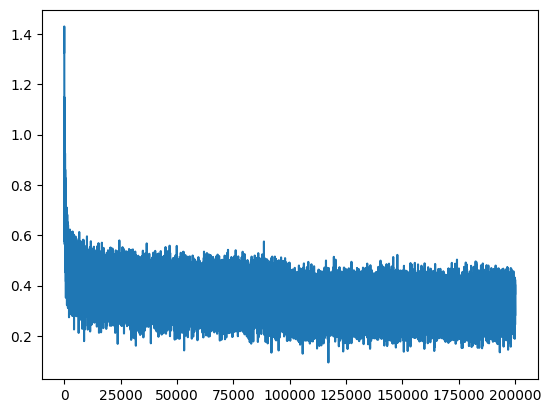

In [34]:
plt.plot(lossi) # before optimization

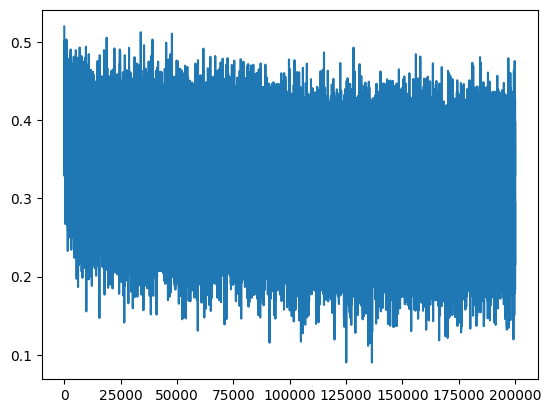

In [33]:
# after
plt.plot(lossi) # no hockey stick

In [63]:
@torch.no_grad() #decorator to disable grad tracking during eval in the function context
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]

  emb = C[x]
  embcat = emb.view(-1, block_size * n_emb)
  h = torch.tanh(embcat @ W1 + B1)
  logits = h @ W2 + B2
  loss = F
  return F.cross_entropy(logits, y).item()

In [64]:
print(split_loss('train'))
print(split_loss('val'))

2.038160800933838
2.105576753616333


In [100]:
# sampling from model

for _ in range(20):

  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + B1)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

jaydella.
laya.
sleenoz.
aitya.
ailenys.
mailyn.
tey.
karrah.
samayana.
devanna.
atjoslit.
conton.
khammariangelda.
unacearia.
yillille.
zen.
popper.
oui.
dmir.
dedero.
